# Лабораторная работа 2
# Фильтр Калмана

## Описание объекта

Рассмотрим модель горизонтального движения надводного судна. Предположим, что сила тяги компенсирует продольное гидродинамическое сопротивление и движение происходит с постоянной скоростью $V_0 = V_x = const$.



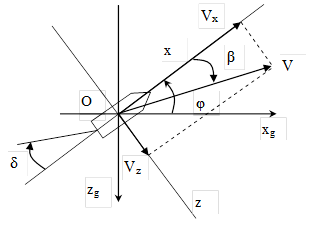

In [21]:
%matplotlib inline
from IPython.display import Image
Image('model.png', width=500)

Динамика движения может быть описана следующей системой уравнений:

$$
\left[
    \begin{array}{c}
        \dot{\varphi} \\
        \dot{\omega} \\
        \dot{V}
    \end{array}
\right] = 

\left[
    \begin{array}{ccc}
        0 & 1 & 0 \\
        0 & a_{22} & a_{23}/V_0 \\
        0 & a_{32}V_0 & a_{33}
    \end{array}
\right] 
\left[
    \begin{array}{c}
        \varphi \\
        \omega \\
        V
    \end{array}
\right] +

\left[
    \begin{array}{c}
        0 \\
        b_{21} \\
        b_{31}
    \end{array}
\right] \delta
$$

где $\phi$ - курс судна, $\omega$ - угловая скорость судна, $V_z$ - поперечная скорость движения судна, $\delta$ - угол поворота руля судна,
$a_{22}=-3$,  $a_{23}=2$, $a_{32}=0.58$, $a_{33}=-5$, $b_{21}=1$, $b_{31}=18$  -  константы.

Измерению доступен курс судна с погрешностью с нормальным распределением и нулевым математическим ожиданием. Отклонение модели от объекта также описывается нормальным распределением с нулевым математическим ожиданием.

## Задание

1. Задать параметры судна.
2. Задать среднеквадратические отклонения модели (курса, угловой скорости и продольной скорости) и датчика.
3. Построить траекторию движения судна при 4 различных положениях руля.
4. Построить фильтр Калмана для оценки состояния судна.
5. Построить графики изменения, измерения и оценки переменных состояния.
6. Получить формулы для определения глобальных координат судна.
7. Построить траеткорию движения судна, ее измерение и оценку.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Задание параметров судна

In [23]:
# Параметры симуляции
sim_t = 10 # время симуляции процесса
dt = 0.2    # временной шаг

In [24]:
### Параметры судна
delta = 0.1 # угол поворота руля судна
V_0 = 20     # начальная скорость судна

# Константы
a_22 = -3
a_23 = 2
a_32 = 0.58
a_33 = -5

b_21 = 1
b_31 = 18

In [25]:
A = np.array([[0, 1,        0],
              [0, a_22,     a_23/V_0],
              [0, a_32*V_0, a_33]])

B = np.array([[0],
              [b_21],
              [b_31]])

C = np.array([[1, 0, 0]])

A = np.eye(3) + A * dt
B = B*dt

### 2. Среднеквадратичные отклонения модели

In [26]:
# Параметры
sigma_fi = 2
sigma_omega = 2
sigma_V = 2

Ex = np.array([[sigma_fi**2,          sigma_omega*sigma_fi, sigma_V*sigma_fi],
               [sigma_fi*sigma_omega, sigma_omega**2,       sigma_V*sigma_omega],
               [sigma_fi*sigma_V,     sigma_omega*sigma_V,  sigma_V**2]])

# Датчик
sigma_z = 0.5
Ez = sigma_z**2

# Шумы
noise_mag = 0.05 # погрешность измерения
omega_noise = 0.1

### 3. Построить траекторию при 4 различных положениях руля

In [27]:
x = np.array([[0], 
              [0], 
              [0]]) # состояние
u = delta

fi = []
omega = []
V = []
t = []
z = []

pos_x_massive = []
pos_y_massive = []
pos_x = 0
pos_y = 0

for i in np.arange(0, sim_t, dt):
    t.append(i)
    noise = [[noise_mag * np.random.normal(0, omega_noise)],
             [noise_mag * np.random.normal(0, omega_noise)],
             [noise_mag * np.random.normal(0, omega_noise)]]
    
    x = A@x + B*u + noise
    
    
    meas_noise = np.random.normal(0, sigma_z)
    y = float(C@x) + meas_noise
    
    # pos_x += x[2][0] * np.sin(x[0][0])
    # pos_y += x[2][0] * np.cos(x[0][0])
    
    # pos_x_massive.append(pos_x)
    # pos_y_massive.append(pos_y)

    fi.append(x[0][0])
    omega.append(x[1][0])
    V.append(x[2][0])   
    z.append(y)
    

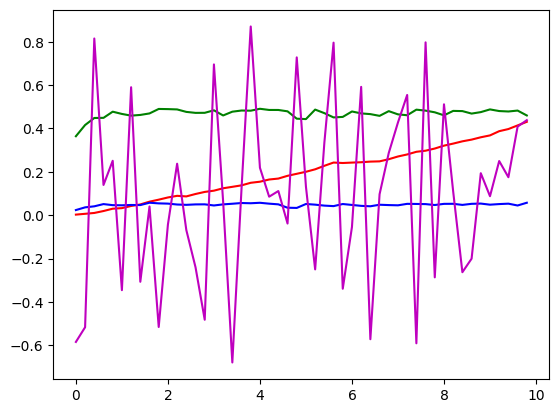

In [28]:
plt.plot(t, fi, c='r')
plt.plot(t, omega, c='b')
plt.plot(t, V, c='g')
plt.plot(t, z, c='m')

### 4. Построить фильтр калмана для оценки состояния судна

In [29]:
fi_est = []
omega_est = []
V_est = []

err = []

x = np.array([[0], 
              [0], 
              [0]]) # состояние

Sigma = Ex.copy()

for i in range(len(t)):
    # Kalman start
    # Предсказание по модели
    x_pred = A@x + B*u #+ noise
    # Оценка сигмы
    Sigma_pred = A@Sigma@A.T + Ez
    # Изменение коэффициента
    K = Sigma_pred@C.T@np.linalg.inv(C@Sigma_pred@C.T + Ez)
    # Объединение предсказания и измерения датчика
    x = x_pred + K@(z[i] - C@x_pred)
    # Обновление ковариации
    Sigma = (np.eye(3) - K@C)@Sigma_pred
    # Kalman end
    
    fi_est.append(x[0][0])
    omega_est.append(x[1][0])
    V_est.append(x[2][0])
    
    err.append(fi[i]-fi_est[i])
   

### 5. Построить графики изменения, измерения и оценки переменных состояния.

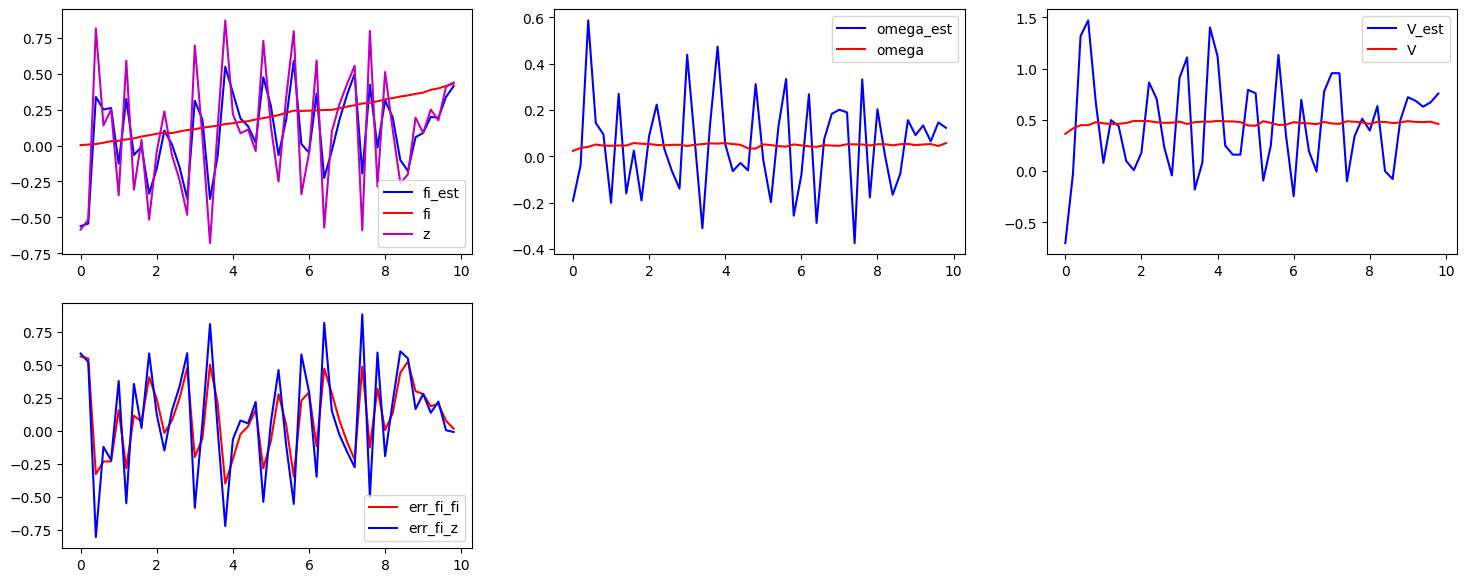

In [42]:
fi_1 = np.float_(fi)
fi_est_1 = np.float_(fi_est)
z1 = np.float_(z)

err_fi_fi = fi_1 - fi_est_1
err_fi_z = fi_1 - z1 

# Настройка размеров подложки
plt.figure(figsize=(18, 7))

plt.subplot(2,3,1)
plt.plot(t, fi_est, c='b', label='fi_est')
plt.plot(t, fi, c='r', label='fi')
plt.plot(t, z, c='m', label = 'z')
plt.legend()

plt.subplot(2,3,2)
plt.plot(t, omega_est, c='b', label='omega_est')
plt.plot(t, omega, c='r', label='omega')
# plt.plot(t, z, c='m')
plt.legend()

plt.subplot(2,3,3)
plt.plot(t, V_est, c='b', label='V_est')
plt.plot(t, V, c='r', label='V')
# plt.plot(t, z, c='m')
plt.legend()

plt.subplot(2,3,4)
plt.plot(t, err_fi_fi, c='r', label='err_fi_fi')
plt.plot(t, err_fi_z, c='b', label='err_fi_z')
plt.legend()


### 6. Получить формулы для определения глобальных координат судна.

In [40]:
pos_x_massive = []
pos_y_massive = []
cosfi = []
pos_x = 0
pos_y = 0

for i in range(len(fi)):
    pos_x += V[i] * np.cos(fi[i]) * dt
    pos_y += V[i] * np.sin(fi[i]) * dt
    
    cosfi.append(np.cos(fi[i]))
    
    pos_x_massive.append(pos_x)
    pos_y_massive.append(pos_y)

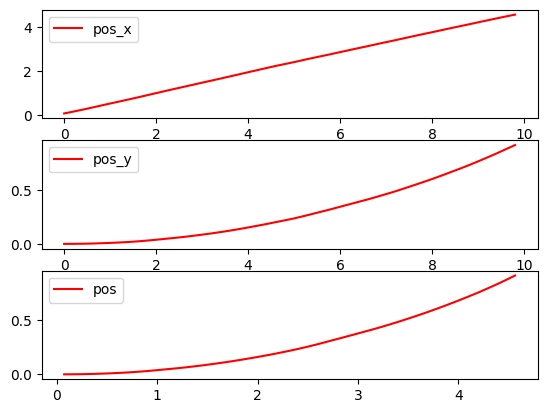

In [41]:
plt.subplot(3,1,1)
plt.plot(t, pos_x_massive, c='r', label='pos_x')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, pos_y_massive, c='r', label='pos_y')
plt.legend()

plt.subplot(3,1,3)
plt.plot(pos_x_massive, pos_y_massive, c='r', label='pos')
plt.legend()